# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [67]:
# Data Handling & File Operations
import os
import json
import time
import numpy as np
import pandas as pd
from pathlib import Path

# Deep Learning with PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler

# Image Processing & Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Dataset & Web Handling
import requests
import tarfile


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [31]:
# defining dataset directory
data_dir = './flowers'

# using pathlib.Path for handling PosixPath
FLOWERS_DIR = Path(data_dir)

# downloading and setting up data if not already present
if not FLOWERS_DIR.is_dir():
    # creating directory
    FLOWERS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Directory created: ./{FLOWERS_DIR}")

    print() # for readability

    # tarball path
    TARBALL = FLOWERS_DIR / "flower_data.tar.gz"

    # downloading and writing the tarball to './flowers' directory
    print(f"[INFO] Downloading the file 'flower_data.tar.gz' to ./{FLOWERS_DIR}")
    request = requests.get('https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz')
    with open(TARBALL, "wb") as file_ref:
        file_ref.write(request.content)
        print(f"[INFO] 'flower_data.tar.gz' saved to ./{FLOWERS_DIR}")

    print() # for readability

    # extracting the downloaded tarball
    print(f"[INFO] Extracting the downloaded tarball to ./{FLOWERS_DIR}")
    with tarfile.open(TARBALL, "r") as tar_ref:
        tar_ref.extractall(FLOWERS_DIR)
        print(f"[INFO] 'flower_data.tar.gz' extracted successfully to ./{FLOWERS_DIR}")

    print() # for readability

    # using os.remove to delete the downloaded tarball
    print("[INFO] Deleting the tarball to save space.")
    os.remove(TARBALL)
else:
    print(f"[INFO] Dataset already setup at ./{FLOWERS_DIR}")

[INFO] Dataset already setup at ./flowers


In [ ]:
'''# TODO: Define your transforms for the training, validation, and testing sets
data_transforms =

# TODO: Load the datasets with ImageFolder
image_datasets =

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders =

In [32]:
# Define transformations for training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [33]:
image_datasets = {
    'train': datasets.ImageFolder("/content/flowers/train", transform=data_transforms['train']),
    'valid': datasets.ImageFolder("/content/flowers/valid", transform=data_transforms['valid']),
    'test': datasets.ImageFolder("/content/flowers/test", transform=data_transforms['test'])
}


In [34]:
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}


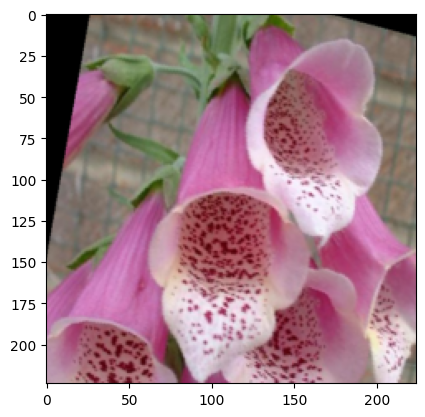

In [36]:
# Function to unnormalize and display an image
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

# Get a batch of training images
images, labels = next(iter(dataloaders['train']))

# Display one image
imshow(images[0])


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#Load category-to-name mapping from a JSON file
with open('/content/drive/MyDrive/aipnd-project-master/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [39]:
# Print first 5 label-name mappings
for key in list(cat_to_name.keys())[:5]:
    print(f"Class {key}: {cat_to_name[key]}")


Class 21: fire lily
Class 3: canterbury bells
Class 45: bolero deep blue
Class 1: pink primrose
Class 34: mexican aster


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [ ]:
# TODO: Build and train your network

In [41]:
print(torch.cuda.is_available())  # Should now print True



True


In [42]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_layer_1_units, hidden_layer_2_units, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_1_units)
        self.fc2 = nn.Linear(hidden_layer_1_units, hidden_layer_2_units)
        self.fc3 = nn.Linear(hidden_layer_2_units, output_size)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

def build_model(arch, hidden_layer_1_units, hidden_layer_2_units):
    if arch == "vgg16":
        model = models.vgg16(pretrained=True)
        input_size = model.classifier[0].in_features
    elif arch == "vgg13":
        model = models.vgg13(pretrained=True)
        input_size = model.classifier[0].in_features
    else:
        raise ValueError("Only 'vgg16' and 'vgg13' architectures are supported.")

    for param in model.parameters():
        param.requires_grad = False  # Freeze feature extraction layers

    model.classifier = Classifier(input_size, hidden_layer_1_units, hidden_layer_2_units, output_size=102)  # Assuming 102 flower classes
    return model


In [43]:
def train_model(model, dataloaders, epochs=5, learning_rate=1e-3, use_gpu=True):
    """
    Trains a model on the dataset.

    Args:
        model (torch.nn.Module): The neural network model.
        dataloaders (dict): Dictionary containing 'train' and 'valid' dataloaders.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        use_gpu (bool): If True, trains on GPU; otherwise, CPU.

    Returns:
        model: The trained model.
    """

    # Define optimizer and loss function
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    print_every = 10
    steps = 0

    for epoch in range(epochs):
        running_loss = 0
        model.train()  # Set model to training mode

        for inputs, labels in dataloaders['train']:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Validate every 10 steps
            if steps % print_every == 0:
                model.eval()  # Set model to evaluation mode
                val_loss = 0
                accuracy = 0

                with torch.no_grad():
                    for inputs, labels in dataloaders['valid']:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        val_loss += criterion(outputs, labels).item()

                        # Compute accuracy
                        ps = torch.exp(outputs)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Validation loss: {val_loss/len(dataloaders['valid']):.3f}.. "
                      f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")

                running_loss = 0
                model.train()  # Set back to training mode

    return model



In [44]:
# Example parameters
arch = "vgg16"
hidden_layer_1_units = 512
hidden_layer_2_units = 256

# Build the model
model = build_model(arch, hidden_layer_1_units, hidden_layer_2_units)

# Print model structure
print(model)

# Example input size for VGG feature extractor
input_size = 25088
hidden_layer_1_units = 512
hidden_layer_2_units = 256
output_size = 102  # Assuming 102 flower categories

# Create classifier
classifier = Classifier(input_size, hidden_layer_1_units, hidden_layer_2_units, output_size)

# Print classifier structure
print(classifier)

# Test with random tensor input
import torch
x = torch.rand(1, input_size)  # Batch of 1
output = classifier(x)
print(output)  # Log-softmax probabilities




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
# Load dataset (assuming `dataloaders` is already defined)

trained_model = train_model(model, dataloaders, epochs=5, learning_rate=1e-3, use_gpu=True)  # Train


Epoch 1/5.. Train loss: 4.728.. Validation loss: 4.366.. Validation accuracy: 0.095
Epoch 1/5.. Train loss: 4.363.. Validation loss: 4.081.. Validation accuracy: 0.153
Epoch 1/5.. Train loss: 4.022.. Validation loss: 3.660.. Validation accuracy: 0.226
Epoch 1/5.. Train loss: 3.791.. Validation loss: 3.407.. Validation accuracy: 0.266
Epoch 1/5.. Train loss: 3.802.. Validation loss: 3.043.. Validation accuracy: 0.342
Epoch 1/5.. Train loss: 3.306.. Validation loss: 2.734.. Validation accuracy: 0.377
Epoch 1/5.. Train loss: 3.256.. Validation loss: 2.453.. Validation accuracy: 0.408
Epoch 1/5.. Train loss: 2.886.. Validation loss: 2.182.. Validation accuracy: 0.461
Epoch 1/5.. Train loss: 2.681.. Validation loss: 2.184.. Validation accuracy: 0.443
Epoch 1/5.. Train loss: 2.589.. Validation loss: 1.858.. Validation accuracy: 0.525
Epoch 1/5.. Train loss: 2.565.. Validation loss: 1.731.. Validation accuracy: 0.545
Epoch 1/5.. Train loss: 2.470.. Validation loss: 1.634.. Validation accuracy

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Do validation on the test set

In [46]:
# Ensure the model is in evaluation mode
model.eval()

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize test loss and accuracy
test_loss = 0
correct = 0
total = 0

# Define loss function if not already defined
criterion = nn.NLLLoss()

# No gradient tracking needed for testing
with torch.no_grad():
    for inputs, labels in dataloaders['test']:  # Ensure testloader exists
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Compute loss

        # Update test loss
        test_loss += loss.item()

        # Get top predicted class
        _, predicted = outputs.topk(1, dim=1)  # Get top class
        equals = predicted == labels.view(*predicted.shape)  # Compare predictions
        correct += torch.sum(equals).item()
        total += labels.size(0)

# Calculate average loss and accuracy
test_loss = test_loss / len(dataloaders['test'])
accuracy = correct / total

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.3f}")  # Should be around 70%+


Test Loss: 0.693
Test Accuracy: 0.808


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint

In [48]:
# Attach class-to-index mapping to model
model.class_to_idx = image_datasets['train'].class_to_idx
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = 5

# Create checkpoint dictionary
checkpoint = {
    'model_name': 'vgg16',
    'classifier': model.classifier,
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'optimizer_state': optimizer.state_dict(),
    'epochs': epochs,
    'class_to_idx': image_datasets['train'].class_to_idx
}

# Save checkpoint
torch.save(checkpoint, 'flower_classifier.pth')

print("Checkpoint saved successfully! ✅")


Checkpoint saved successfully! ✅


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

In [49]:
def load_checkpoint(filepath):
    # Load the saved checkpoint
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))  # Use 'cuda' if using GPU

    # Load the pre-trained model architecture
    model = models.vgg16(pretrained=True)

    # Freeze feature extractor parameters
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier with saved classifier
    model.classifier = checkpoint['classifier']

    # Load state dictionary (trained weights)
    model.load_state_dict(checkpoint['state_dict'])

    # Load class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']

    print("Checkpoint loaded successfully! ✅")

    return model

# Load the model
model = load_checkpoint('flower_classifier.pth')

# Set model to evaluation mode
model.eval()


<ipython-input-49-892d3fee89c5>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=torch.device('cpu'))  # Use 'cuda' if using G

Checkpoint loaded successfully! ✅


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [50]:
def process_image(image_path):
  """Preprocess an image to make it model-ready."""
  image = Image.open(image_path).convert("RGB")  # Convert to RGB

    # Resize while keeping aspect ratio
  image.thumbnail((256, 256))

    # Center crop to 224x224
  left = (image.width - 224) / 2
  top = (image.height - 224) / 2
  right = left + 224
  bottom = top + 224
  image = image.crop((left, top, right, bottom))

    # Convert image to numpy array
  np_image = np.array(image) / 255.0  # Scale pixel values

    # Normalize using the same values as training
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  np_image = (np_image - mean) / std

    # Reorder dimensions (H, W, C) -> (C, H, W)
  np_image = np_image.transpose((2, 0, 1))

  return torch.tensor(np_image, dtype=torch.float32)


def predict(image_path, model, topk=5):
    """Predict the class of an image using a trained model."""
    model.eval()  # Set model to evaluation mode
    model.cpu()   # Run inference on CPU

    # Preprocess image
    image = process_image(image_path)
    image = image.unsqueeze(0)  # Add batch dimension

    # Forward pass through model
    with torch.no_grad():
        output = model(image)
        probs, indices = torch.topk(torch.softmax(output, dim=1), topk)

    # Convert to numpy arrays
    probs = probs.numpy().flatten()
    indices = indices.numpy().flatten()

    # Convert indices to class labels
    class_to_idx = model.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    classes = [idx_to_class[i] for i in indices]

    return probs, classes

# Example usage
image_path = "/content/drive/MyDrive/aipnd-project-master/assets/Flowers.png"  # Replace with actual image path
probs, classes = predict(image_path, model)

print(probs)   # Predicted probabilities
print(classes) # Predicted class labels


[0.54798204 0.11446965 0.09044981 0.07283448 0.04385277]
['62', '78', '7', '2', '96']


In [51]:
# Load class mapping from a JSON file (if available)
with open('/content/drive/MyDrive/aipnd-project-master/cat_to_name.json', 'r') as f:
    class_to_name = json.load(f)

# Convert class indices to names
predicted_names = [class_to_name[i] for i in classes]
print(predicted_names)


['japanese anemone', 'lotus lotus', 'moon orchid', 'hard-leaved pocket orchid', 'camellia']


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [52]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

<Axes: >

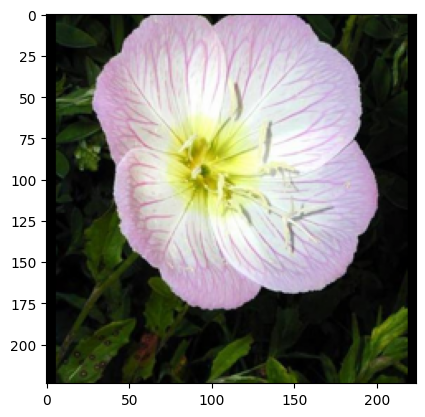

In [53]:
# Choose an image to test
image_path = '/content/flowers/test/1/image_06743.jpg'  # Change this to an actual image path

# Process the image
processed_image = process_image(image_path)

# Convert to a tensor for displaying
tensor_image = processed_image

# Display the image
imshow(tensor_image)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [54]:
def process_image(image_path):
    """Process an image to match the input requirements of the model."""
    # Open image
    image = Image.open(image_path)

    # Define transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Apply transformations
    return transform(image)

def predict(image_path, model, topk=5):
    """Predict the class (or classes) of an image using a trained deep learning model."""
    # Process image
    image = process_image(image_path)

    # Add batch dimension
    image = image.unsqueeze(0)

    # Move model to evaluation mode
    model.eval()

    # Disable gradient calculation (for inference)
    with torch.no_grad():
        output = model(image)

    # Convert output to probabilities
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get top-k probabilities and indices
    top_probs, top_indices = probabilities.topk(topk)

    # Convert to NumPy arrays
    top_probs = top_probs.numpy()
    top_indices = top_indices.numpy()

    # Invert class_to_idx to get class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_indices]

    return top_probs, top_classes

# Example Usage
probs, classes = predict("/content/flowers/test/1/image_06743.jpg",model)
print(probs)
print(classes)


[0.87357044 0.04181087 0.02251889 0.02119968 0.0145403 ]
['1', '83', '86', '97', '18']


In [55]:
flower_names = [class_to_name[c] for c in classes]
print(flower_names)


['pink primrose', 'hibiscus', 'tree mallow', 'mallow', 'peruvian lily']


Text(0.5, 1.0, 'Predicted: pink primrose')

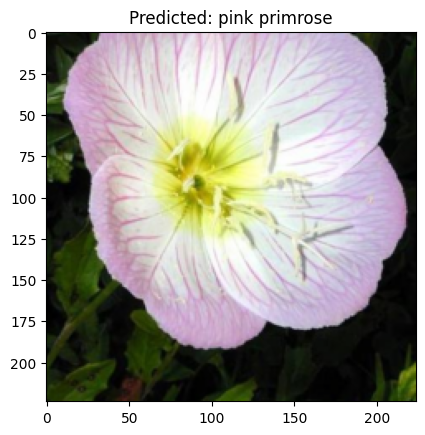

In [56]:
imshow(process_image("/content/flowers/test/1/image_06743.jpg"))
plt.title(f"Predicted: {class_to_name[classes[0]]}")


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

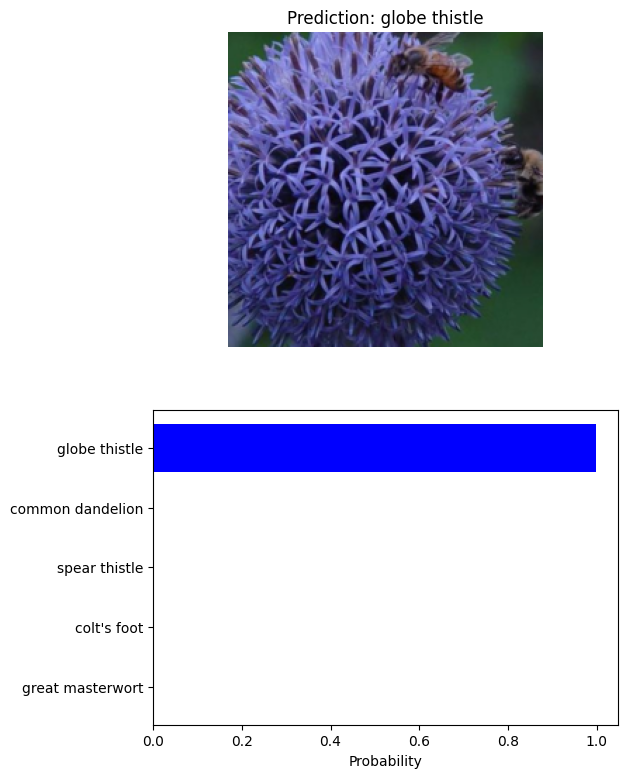

In [57]:
# Load the class-to-name mapping
with open('/content/drive/MyDrive/aipnd-project-master/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

def view_classify(image_path, model, topk=5):
    """Displays an image along with the top 5 predicted classes and probabilities."""

    # Process the image
    processed_image = process_image(image_path)

    # Predict the top K classes
    probs, classes = predict(image_path, model, topk=topk)

    # Convert class indices to actual names
    flower_names = [cat_to_name[str(cls)] for cls in classes]

    # Convert image tensor to display format
    image = processed_image.numpy().squeeze()  # Remove unnecessary dimensions
    image = image.transpose((1, 2, 0))  # Convert to (H, W, C) format

    # Undo normalization for proper display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Clip values between 0 and 1

    # Create a figure with 2 subplots (image + bar chart)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)

    # Display the image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f"Prediction: {flower_names[0]}")

    # Display the probability bar chart
    y_pos = np.arange(len(flower_names))
    ax2.barh(y_pos, probs, color='blue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # Highest probability at the top
    ax2.set_xlabel("Probability")

    plt.show()

# Test with an image
view_classify("/content/flowers/test/10/image_07090.jpg", model)


In [58]:
%%writefile train.py
###
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Function to load data
def load_data(data_dir):
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    image_datasets = {
        'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
        'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
        'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
    }

    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
        'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False),
        'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
    }

    return dataloaders, image_datasets

# Define the classifier class
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_layer_1_units, hidden_layer_2_units, output_size=102):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_1_units)
        self.fc2 = nn.Linear(hidden_layer_1_units, hidden_layer_2_units)
        self.fc3 = nn.Linear(hidden_layer_2_units, output_size)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Function to build the model
def build_model(arch, hidden_layer_1_units, hidden_layer_2_units):
    if arch == "vgg16":
        model = models.vgg16(pretrained=True)
    elif arch == "vgg13":
        model = models.vgg13(pretrained=True)
    else:
        raise ValueError("Only 'vgg16' and 'vgg13' architectures are supported.")

    input_size = model.classifier[0].in_features

    for param in model.parameters():
        param.requires_grad = False  # Freeze feature extraction layers

    model.classifier = Classifier(input_size, hidden_layer_1_units, hidden_layer_2_units)
    return model

# Function to train the model
def train_model(model, dataloaders, epochs=5, learning_rate=1e-3, use_gpu=True):
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    print_every = 10
    steps = 0

    for epoch in range(epochs):
        running_loss = 0
        model.train()

        for inputs, labels in dataloaders['train']:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                val_loss = 0
                accuracy = 0

                with torch.no_grad():
                    for inputs, labels in dataloaders['valid']:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        val_loss += criterion(outputs, labels).item()

                        ps = torch.exp(outputs)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Validation loss: {val_loss/len(dataloaders['valid']):.3f}.. "
                      f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")

                running_loss = 0
                model.train()

    return model

# Function to save checkpoint
def save_checkpoint(model, optimizer, image_datasets, save_path="flower_classifier.pth"):
    model.class_to_idx = image_datasets['train'].class_to_idx
    checkpoint = {
        'model_name': 'vgg16',
        'classifier': model.classifier,
        'state_dict': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'class_to_idx': model.class_to_idx
    }
    torch.save(checkpoint, save_path)
    print(f"Model saved successfully at {save_path}!")



# Main execution
def main():
    parser = argparse.ArgumentParser(description="Train a neural network on flower data.")
    parser.add_argument("data_directory", type=str, help="Path to the dataset")
    parser.add_argument("--save_dir", type=str, default="saved_models", help="Directory to save checkpoints")
    parser.add_argument("--arch", type=str, default="vgg16", help="Model architecture")
    parser.add_argument("--learning_rate", type=float, default=0.01, help="Learning rate")
    parser.add_argument("--hidden_layer_1_units", type=int, default=512, help="Hidden layer 1 units")
    parser.add_argument("--hidden_layer_2_units", type=int, default=256, help="Hidden layer 2 units")
    parser.add_argument("--epochs", type=int, default=20, help="Number of epochs")
    parser.add_argument("--gpu", action="store_true", help="Use GPU for training")
    args = parser.parse_args()

    dataloaders, image_datasets = load_data(args.data_directory)
    model = build_model(args.arch, args.hidden_layer_1_units, args.hidden_layer_2_units)
    trained_model = train_model(model, dataloaders, args.epochs, args.learning_rate, args.gpu)
    save_checkpoint(trained_model, optim.Adam(model.classifier.parameters(), lr=args.learning_rate), image_datasets, f"{args.save_dir}/flower_classifier.pth")

if __name__ == '__main__':
    main()


Writing train.py


In [60]:
!mkdir saved_models



In [61]:
%run train.py ./flowers --arch vgg16 --epochs 5 --learning_rate 0.001  --hidden_layer_1_units 512 --hidden_layer_2_units 256  --gpu


Epoch 1/5.. Train loss: 4.732.. Validation loss: 4.354.. Validation accuracy: 0.062
Epoch 1/5.. Train loss: 4.422.. Validation loss: 4.131.. Validation accuracy: 0.097
Epoch 1/5.. Train loss: 4.195.. Validation loss: 3.756.. Validation accuracy: 0.166
Epoch 1/5.. Train loss: 3.949.. Validation loss: 3.441.. Validation accuracy: 0.259
Epoch 1/5.. Train loss: 3.397.. Validation loss: 3.214.. Validation accuracy: 0.243
Epoch 1/5.. Train loss: 3.496.. Validation loss: 2.925.. Validation accuracy: 0.357
Epoch 1/5.. Train loss: 3.267.. Validation loss: 2.537.. Validation accuracy: 0.401
Epoch 1/5.. Train loss: 3.087.. Validation loss: 2.311.. Validation accuracy: 0.449
Epoch 1/5.. Train loss: 2.774.. Validation loss: 2.108.. Validation accuracy: 0.481
Epoch 1/5.. Train loss: 2.600.. Validation loss: 1.926.. Validation accuracy: 0.526
Epoch 1/5.. Train loss: 2.650.. Validation loss: 1.863.. Validation accuracy: 0.505
Epoch 1/5.. Train loss: 2.371.. Validation loss: 1.729.. Validation accuracy

In [63]:
%%writefile predict.py
###
import argparse
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import VGG16_Weights
from PIL import Image
import numpy as np
import json
from train import Classifier  # Import the custom classifier


def load_checkpoint(filepath):
    """Load a trained model from a checkpoint file safely."""
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'), weights_only=False)

    # Print checkpoint keys for debugging
    print("Checkpoint keys:", checkpoint.keys())

    # Load pre-trained VGG16 model
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

    # Freeze feature extractor parameters
    for param in model.features.parameters():
        param.requires_grad = False

    # Retrieve classifier parameters from checkpoint
    input_size = checkpoint.get('input_size', 25088)  # Default for VGG16
    hidden_layer_1 = checkpoint.get('hidden_layer_1_units', 512)
    hidden_layer_2 = checkpoint.get('hidden_layer_2_units', 256)
    output_size = checkpoint.get('output_size', 102)  # Default for 102 flower classes

    # Rebuild classifier
    model.classifier = Classifier(input_size, hidden_layer_1, hidden_layer_2, output_size)

    # Load trained weights
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    else:
        print("ERROR: 'state_dict' missing! Ensure correct checkpoint format.")

    # Load class-to-index mapping
    model.class_to_idx = checkpoint.get('class_to_idx', {})

    print("Checkpoint loaded successfully!")
    return model


def process_image(image_path):
    """Preprocess an image for model inference."""
    image = Image.open(image_path).convert("RGB")  # Convert to RGB

    # Resize to maintain aspect ratio
    image = image.resize((256, 256))

    # Center crop to 224x224
    left = (image.width - 224) / 2
    top = (image.height - 224) / 2
    right = left + 224
    bottom = top + 224
    image = image.crop((left, top, right, bottom))

    # Convert image to numpy array and normalize
    np_image = np.array(image) / 255.0  # Scale pixel values
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions (H, W, C) -> (C, H, W)
    np_image = np_image.transpose((2, 0, 1))

    return torch.tensor(np_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension


def predict(image_path, model, topk=5, device="cpu"):
    """Predict the top K classes for a given image."""
    model.to(device)
    model.eval()  # Set to evaluation mode

    # Preprocess the image
    image = process_image(image_path).to(device)

    # Forward pass through the model
    with torch.no_grad():
        output = model(image)
        probs, indices = torch.topk(F.softmax(output, dim=1), topk)

    # Convert to numpy arrays
    probs = probs.cpu().numpy().flatten()
    indices = indices.cpu().numpy().flatten()

    # Convert indices to class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[i] for i in indices]

    return probs, classes


def main():
    """Main function for parsing arguments and running inference."""
    parser = argparse.ArgumentParser(description="Predict flower name from an image using a trained network.")
    parser.add_argument("imagepath", type=str, help="Path to the input image")
    parser.add_argument("checkpoint", type=str, help="Path to the model checkpoint")
    parser.add_argument("--top_k", type=int, default=5, help="Return top K most likely classes")
    parser.add_argument("--category_names", type=str, help="Path to JSON file mapping categories to real names")
    parser.add_argument("--gpu", action="store_true", help="Use GPU for inference")
    args = parser.parse_args()

    # Select device (GPU if available and specified)
    device = "cuda" if args.gpu and torch.cuda.is_available() else "cpu"

    # Load model
    model = load_checkpoint(args.checkpoint)
    model.to(device)

    # Run prediction
    probs, classes = predict(args.imagepath, model, args.top_k, device)

    # Convert class indices to real names if mapping is provided
    if args.category_names:
        try:
            with open(args.category_names, 'r') as f:
                cat_to_name = json.load(f)
            classes = [cat_to_name.get(str(cls), cls) for cls in classes]
        except Exception as e:
            print(f"Error loading category names: {e}")

    # Print results
    print("\n🔹 Predicted Classes:", classes)
    print("🔹 Probabilities:", probs)


if __name__ == '__main__':
    main()


Overwriting predict.py


In [66]:
%run predict.py /content/flowers/test/1/image_06764.jpg /content/saved_models/flower_classifier.pth --top_k 5 --category_names /content/drive/MyDrive/aipnd-project-master/cat_to_name.json --gpu

Checkpoint keys: dict_keys(['model_name', 'classifier', 'state_dict', 'optimizer_state', 'class_to_idx'])
Checkpoint loaded successfully!

🔹 Predicted Classes: ['mallow', 'pink primrose', 'mexican petunia', 'camellia', 'hippeastrum']
🔹 Probabilities: [0.7104939  0.11846252 0.0464892  0.02659713 0.02243627]
